# Spotify Music Artists On The Top 100 Songs Chart - How Many Top Trending YouTube Videos Did They Have in 2018
---

### SCOPE:
#### - Extracted, transformed, and loaded up Spotify's Top 100 Songs of 2018, and YouTube's Top Trending Videos from December 2017 thru May 2018 for their videos categorized as music only. I then created an "Artist" column to enable joining with and used a nested loop to answer the question. Both dataframes were loaded into MySQL using SQL Alchemy.


### PURPOSE:
#### - I choose this project because I'm a avid listener and a huge music and concert goer, and wanted to work with data that I was familiar with.

### Data Sources:
#### - https://www.kaggle.com/datasnaek/youtube-new (this is an updated link, whereas I used an older version of this file, which is attached in the resources)
#### - https://www.kaggle.com/nadintamer/top-spotify-tracks-of-2018
 


In [1]:
# Import Dependencies 1/2:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import os
import csv
import json
import simplejson
import numpy as np
import pandas as pd
from datetime import datetime
import sys
import string

## Part 1) SQL Alchemy setup and built a search, create, and drop database function to set up loading phase after extraction and transformation of data

In [2]:
# Import Dependencies 2/2:
from sqlalchemy import create_engine, Column, Integer, String, join, Date, Table, MetaData
from sqlalchemy.orm import Session
from sqlalchemy.sql import select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy_utils import database_exists, create_database, drop_database, has_index
import pymysql

Base = declarative_base()

In [3]:
#rds_connection_string = "<inser user name>:<insert password>@127.0.0.1/customer_db"
rds_connection_string = "root:gREATNESS23$@127.0.0.1/" #youtube_spotify_2018_db"

# Can set up an input for the db_name later (optional)
#db_name = input("What database would you like to search for?")
db_name = 'youtube_spotify_2018_db2'

# Setup engine connection string
#engine = create_engine(f'mysql://{rds_connection_string}{db_name}?charset=utf8')
engine = create_engine(f'mysql://{rds_connection_string}{db_name}?charset=utf8', echo=True)

In [4]:
# Created a function incorproating SQL Alchemy to search, create, and or drop a database:
def search_create_drop_db(db_name):
    #db_exist = database_exists(f'mysql://{rds_connection_string}youtube_spotify_2018_db2')
    db_exist = database_exists(f'mysql://{rds_connection_string}{db_name}')
    db_url = f'mysql://{rds_connection_string}{db_name}'
    if db_exist == True:
        drop_table_y_or_n = input(f'"{db_name}" database already exists in MySQL. Do you want you drop the table? Enter exactly: "y" or "n".  ')
        if drop_table_y_or_n == 'y':
            drop_database(db_url)
            print(f"Database {db_name} was dropped")
            create_new_db = input(f"Do you want to create another database called: {db_name}?  ")
            if create_new_db == 'y':
                create_database(db_url)
                return(f"The database {db_name} was created. Next You will need to create tables for this database.  ")
            else:
                return("No database was created. Goodbye!  ")
        else:
            return("The database exists. No action was taken. Goodbye!  ")
    else:
        create_database(db_url)
        return(f"The queried database did not exist, and was created as: {db_name} .  ")

search_create_drop_db(db_name)

"youtube_spotify_2018_db2" database already exists in MySQL. Do you want you drop the table? Enter exactly: "y" or "n".  y
Database youtube_spotify_2018_db2 was dropped
Do you want to create another database called: youtube_spotify_2018_db2?  y


'The database youtube_spotify_2018_db2 was created. Next You will need to create tables for this database.  '

In [5]:
# # Create CLASSES / AKA tables 'blueprints' using python classes and sql alchemy:
# # This would be useful say if I was to use SQL Alchemy to import a sqllite file into python

# class yt_categories(Base):
#     __tablename__ = 'yt_category_titles'
#     id = Column(Integer, primary_key=True)
#     category_title = Column(String(60))

# class yt_statistics_data(Base):
#     __tablename__ = 'yt_statistics'
#     id = Column(Integer, primary_key=True)
#     category_title = Column(String(60))
#     trending_date = Column(Date, nullable=False)
#     video_title = Column(String(200))
#     channel_title = Column(String(100))
#     category_id = Column(Integer)
#     views = Column(Integer)
#     likes = Column(Integer)
#     dislikes = Column(Integer)
#     view_count = Column(Integer)

# class spotify_music_data(Base):
#     __tablename__ = 'spotify_music'
#     id = Column(Integer, primary_key=True)
#     artist = Column(String(100))
#     song_name = Column(String(200))
#     spotify_unique_id = Column(String(100))


In [6]:
# Create tables 'blueprints' using python classes and sql alchemy:

meta = MetaData()
conn = engine.connect()

yt_categories = Table(
   'yt_categories', meta, 
   Column('category_id', Integer, primary_key = True), 
   Column('category_title', String)
)

yt_statistics = Table(
   'yt_statistics', meta,
   Column('id', Integer, primary_key = True),
   Column('trending_date', Date, nullable=False),
   Column('video_title', String),
   Column('channel_title', String),
   Column('category_id', Integer),
   Column('views', Integer),
   Column('likes', Integer),
   Column('dislikes', Integer),
   Column('comment_count', Integer)
)

spotify_2018top100_data = Table(
   'spotify_2018top100_data', meta,
   Column('Artist', String, primary_key = True),
   Column('song_name', String),
   Column('unique_id', String)
)



2020-04-03 19:57:23,648 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2020-04-03 19:57:23,651 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:23,657 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2020-04-03 19:57:23,659 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:23,666 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2020-04-03 19:57:23,669 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:23,671 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2020-04-03 19:57:23,672 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:23,676 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2020-04-03 19:57:23,678 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:23,680 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2020-04-03 19:57:23,682 INFO sqlalchemy.engine.base.E

## Part 2a) ETL on the "YouTube Categories" JSON dataset:
### Extraction, transformation, load, and read using 2 methods from MySQL Database 

In [7]:
# YouTube data has two parts: 1) Categories information in JSON format
                            # 2) Top Trending US YouTube Videos in a CSV file

# Part 1) YouTube Categories are seperated in a json file
yt_json_file = './resources/youtube_US_category_id.json'
yt_rawjson_df = pd.read_json(yt_json_file)

In [8]:
# Extract the category id and category titles, and set them into a list

# for i in yt_rawjson_df['items']:
#     #print(i['id'])
#     print(i['id'] + ' | ' + i['snippet']['title'])
    

category_id = [int(i['id']) for i in yt_rawjson_df['items']]
category_title = [str(i['snippet']['title']) for i in yt_rawjson_df['items']]

# Create a dataframe of the category id and title for later use
category_id_title_df = pd.DataFrame({'category_id': category_id, 'category_title': category_title})
category_id_title_df.head()
category_id_title_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
category_id       32 non-null int64
category_title    32 non-null object
dtypes: int64(1), object(1)
memory usage: 592.0+ bytes


In [9]:
# Drop Dulplicates and Sort by category_title
category_id_title_df.drop_duplicates(['category_id', 'category_title']).sort_values(by=['category_title'],
                                                                                    ascending=False).head()

category_id   category_title
8            21    Videoblogging
6            19  Travel & Events
31           44         Trailers
28           41         Thriller
4            17           Sports

In [10]:
# Load category_id_title_df to MySQL with Pandas
category_id_title_df.to_sql('yt_categories', con=engine, if_exists='append')

2020-04-03 19:57:27,025 INFO sqlalchemy.engine.base.Engine DESCRIBE `yt_categories`
2020-04-03 19:57:27,028 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:27,035 INFO sqlalchemy.engine.base.Engine ROLLBACK
2020-04-03 19:57:27,045 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE yt_categories (
	`index` BIGINT, 
	category_id BIGINT, 
	category_title TEXT
)


2020-04-03 19:57:27,049 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:27,099 INFO sqlalchemy.engine.base.Engine COMMIT
2020-04-03 19:57:27,105 INFO sqlalchemy.engine.base.Engine CREATE INDEX ix_yt_categories_index ON yt_categories (`index`)
2020-04-03 19:57:27,107 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:27,143 INFO sqlalchemy.engine.base.Engine COMMIT
2020-04-03 19:57:27,150 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-04-03 19:57:27,153 INFO sqlalchemy.engine.base.Engine INSERT INTO yt_categories (`index`, category_id, category_title) VALUES (%s, %s, %s)
2020-04-03 19:57:27,156 INFO sqlal

In [11]:
# Two ways in this notebook to pull the data directly from MySQL database
# Method 1) Use SQL Alchemy Engine - Result: successfully reads from MySQL Database:
engine.execute("SELECT * FROM yt_categories").fetchall()

2020-04-03 19:57:27,181 INFO sqlalchemy.engine.base.Engine SELECT * FROM yt_categories
2020-04-03 19:57:27,182 INFO sqlalchemy.engine.base.Engine ()


[(0, 1, 'Film & Animation'),
 (1, 2, 'Autos & Vehicles'),
 (2, 10, 'Music'),
 (3, 15, 'Pets & Animals'),
 (4, 17, 'Sports'),
 (5, 18, 'Short Movies'),
 (6, 19, 'Travel & Events'),
 (7, 20, 'Gaming'),
 (8, 21, 'Videoblogging'),
 (9, 22, 'People & Blogs'),
 (10, 23, 'Comedy'),
 (11, 24, 'Entertainment'),
 (12, 25, 'News & Politics'),
 (13, 26, 'Howto & Style'),
 (14, 27, 'Education'),
 (15, 28, 'Science & Technology'),
 (16, 29, 'Nonprofits & Activism'),
 (17, 30, 'Movies'),
 (18, 31, 'Anime/Animation'),
 (19, 32, 'Action/Adventure'),
 (20, 33, 'Classics'),
 (21, 34, 'Comedy'),
 (22, 35, 'Documentary'),
 (23, 36, 'Drama'),
 (24, 37, 'Family'),
 (25, 38, 'Foreign'),
 (26, 39, 'Horror'),
 (27, 40, 'Sci-Fi/Fantasy'),
 (28, 41, 'Thriller'),
 (29, 42, 'Shorts'),
 (30, 43, 'Shows'),
 (31, 44, 'Trailers')]

In [12]:
# Method 2) Read from MySQL database using Pandas - Result: Success! - This method is a better setup for analysis.
# The index column is automatically generated.
yt_cat_df = pd.read_sql_query('SELECT * FROM yt_categories', con=engine)
yt_cat_df.head()

2020-04-03 19:57:27,344 INFO sqlalchemy.engine.base.Engine SELECT * FROM yt_categories
2020-04-03 19:57:27,346 INFO sqlalchemy.engine.base.Engine ()


index  category_id    category_title
0      0            1  Film & Animation
1      1            2  Autos & Vehicles
2      2           10             Music
3      3           15    Pets & Animals
4      4           17            Sports

## Part 2b) ETL on the "YouTube Top Trending US Videos" dataset:
### Extraction, transformation, load, and read using 2 methods from MySQL Database 

In [13]:
# Part 1) is the YouTube Top US Videos in a CSV
csv_file_yt = "./resources/youtube_USvideos.csv"
yt_rawdata_df = pd.read_csv(csv_file_yt, encoding='utf-8')

In [14]:
# view rows, count and datatypes
yt_rawdata_df
yt_rawdata_df['id'] = yt_rawdata_df.index
yt_rawdata_df.head(1)

video_id trending_date                               title  \
0  2kyS6SvSYSE      17.14.11  WE WANT TO TALK ABOUT OUR MARRIAGE   

  channel_title  category_id              publish_time             tags  \
0  CaseyNeistat           22  2017-11-13T17:13:01.000Z  SHANtell martin   

    views  likes  dislikes  comment_count  \
0  748374  57527      2966          15954   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg              False   

   ratings_disabled  video_error_or_removed  \
0             False                   False   

                                         description  id  
0  SHANTELL'S CHANNEL - https://www.youtube.com/s...   0

In [15]:
# Rename Columns
yt_statistics_data_df = yt_rawdata_df.rename(columns={
                                                "title":"video_title",
                                                "category_id":"category_id"
                                               })
yt_statistics_data_df.head()

video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                         video_title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1  last week tonight trump presidency|"last week ...  2418783   97185   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  3191434  146033   
3  rhett and link|"gmm"|"good mythical morning"|"...   343168   10172   
4  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  2095731  132235   

   dislikes  comment_count                                  thumbnail_link  \
0      2966          15954  https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg   
1      6146          12703  https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg   
2      5339           8181  https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg   
3       666           2146  https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg   
4      1989          17518  https://i.ytimg.com/vi/d380meD0W0M/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1              False             False                   False   
2              False             False                   False   
3              False             False                   False   
4              False             False                   False   

                                         description  id  
0  SHANTELL'S CHANNEL - https://www.youtube.com/s...   0  
1  One year after the presidential election, John...   1  
2  WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...   2  
3  Today we find out if Link is a Nickelback amat...   3  
4  I know it's been a while since we did this sho...   4

In [16]:
# Drop Cells with Missing Information
yt_statistics_data_df = yt_statistics_data_df.dropna(how="any")

In [17]:
# Drop Dulplicates and Sort by Trending Date
yt_statistics_data_df.drop_duplicates(['video_id', 'trending_date', 'video_title', 'channel_title',
                                       'category_id', 'publish_time', 'views', 'likes', 'dislikes',
                                       'comment_count']).sort_values(by=['trending_date'], ascending=False).head()

video_id trending_date  \
38051  EqeIRzY7hIU      18.31.05   
38103  MAjY8mCTXWk      18.31.05   
38081  LzuDyq0-1LM      18.31.05   
38082  6SuMbFuKDf8      18.31.05   
38083  yDiXQl7grPQ      18.31.05   

                                             video_title       channel_title  \
38051                  6 Cheese Gadgets put to the Test!  CrazyRussianHacker   
38103  周杰倫 Jay Chou【不愛我就拉倒 If You Don't Love Me, It's...     杰威爾音樂 JVR Music   
38081  Why it's not a British royal wedding without f...                 Vox   
38082  Backstreet Boys - Don't Go Breaking My Heart (...  BackstreetBoysVEVO   
38083  Do You Hear Yanny or Laurel? (SOLVED with SCIE...         AsapSCIENCE   

       category_id              publish_time  \
38051           28  2018-05-20T18:58:15.000Z   
38103           10  2018-05-14T15:59:47.000Z   
38081           25  2018-05-18T11:00:03.000Z   
38082           10  2018-05-17T04:00:01.000Z   
38083           28  2018-05-16T18:16:26.000Z   

                                                    tags     views   likes  \
38051  Cheese Gadgets|"Gadgets"|"Cheese"|"kitchen gad...   1519038   26770   
38103  周杰倫|"Jay"|"Chou"|"周董"|"周杰伦"|"周傑倫"|"杰威尔"|"周周"|"...  17259071  132009   
38081  pop culture|"royal wedding"|"fancy hats"|"prin...    484199    8246   
38082  Backstreet Boys|"Don't Go Breaking My Heart"|"...  14717193  396826   
38083  AsapSCIENCE|"audio illusion"|"yanny"|"laurel"|...  42667467  564046   

       dislikes  comment_count  \
38051      1557           2875   
38103      9552          14789   
38081       662            761   
38082     16015          39035   
38083     33508         180469   

                                       thumbnail_link  comments_disabled  \
38051  https://i.ytimg.com/vi/EqeIRzY7hIU/default.jpg              False   
38103  https://i.ytimg.com/vi/MAjY8mCTXWk/default.jpg              False   
38081  https://i.ytimg.com/vi/LzuDyq0-1LM/default.jpg              False   
38082  https://i.ytimg.com/vi/6SuMbFuKDf8/default.jpg              False   
38083  https://i.ytimg.com/vi/yDiXQl7grPQ/default.jpg              False   

       ratings_disabled  video_error_or_removed  \
38051             False                   False   
38103             False                   False   
38081             False                   False   
38082             False                   False   
38083             False                   False   

                                             description     id  
38051  $1000 Survival Kit in a Case - https://youtu.b...  38051  
38103  詞：周杰倫、宋健彰（彈頭）  曲：周杰倫MV導演：周杰倫憂鬱型男的走心旋律  用英式搖滾宣洩...  38103  
38081  Fantastical fascinators at royal weddings are ...  38081  
38082  Get the Backstreet Boys new single “Don’t Go B...  38082  
38083  Yanny vs. Laurel audio illusion solved! PHEW F...  38083

In [18]:
# Drop Unwanted Columns

to_drop =['video_id', 'publish_time', 'tags', 'thumbnail_link', 'comments_disabled',
          'ratings_disabled', 'video_error_or_removed', 'description']

yt_statistics_data_df.drop(to_drop, inplace=True, axis=1)
yt_statistics_data_df.head(1)

trending_date                         video_title channel_title  \
0      17.14.11  WE WANT TO TALK ABOUT OUR MARRIAGE  CaseyNeistat   

   category_id   views  likes  dislikes  comment_count  id  
0           22  748374  57527      2966          15954   0

In [19]:
# Reorganize columns to match SQL Alchemy Table

cols = yt_statistics_data_df.columns.tolist()
cols = cols[-1:] + cols[0:-1]
cols
yt_statistics_data_df = yt_statistics_data_df[cols]

In [20]:
# Replace the "." in Trending Date to "-"

yt_statistics_data_df['trending_date'] = [x.replace(".","-") for x in yt_statistics_data_df['trending_date']]
yt_statistics_data_df.head()

id trending_date                                        video_title  \
0   0      17-14-11                 WE WANT TO TALK ABOUT OUR MARRIAGE   
1   1      17-14-11  The Trump Presidency: Last Week Tonight with J...   
2   2      17-14-11  Racist Superman | Rudy Mancuso, King Bach & Le...   
3   3      17-14-11                   Nickelback Lyrics: Real or Fake?   
4   4      17-14-11                           I Dare You: GOING BALD!?   

           channel_title  category_id    views   likes  dislikes  \
0           CaseyNeistat           22   748374   57527      2966   
1        LastWeekTonight           24  2418783   97185      6146   
2           Rudy Mancuso           23  3191434  146033      5339   
3  Good Mythical Morning           24   343168   10172       666   
4               nigahiga           24  2095731  132235      1989   

   comment_count  
0          15954  
1          12703  
2           8181  
3           2146  
4          17518

In [21]:
# Pulled up this dataframe verify exactly how "Music" was spelled for the following step:
category_id_title_df['category_title'].value_counts().head()

Comedy             2
Music              1
Thriller           1
Sports             1
Travel & Events    1
Name: category_title, dtype: int64

In [22]:
# Used Pandas Merge aka (Join in Relational DB) Inner joined the Both YouTube Tables to find what Category_id 10 means:

yt_merged_df = pd.merge(yt_statistics_data_df, category_id_title_df, how='inner', on='category_id',
         left_index=False, right_index=False, sort=False)

yt_musicdata_df = yt_merged_df[yt_merged_df['category_title']  == 'Music']

In [23]:
# Only going to clean and focus on YT videos that are in the "Music" category_title:

# Clean Channel Title Column to set up the MAIN LOOP

yt_musicdata_df['channel_title'] = [x.replace("VEVO","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace("vevo","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace("Vevo","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace("Official","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace("official","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace("OFFICIAL","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace("You Tube Channel","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace("Music","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace("music","") for x in yt_musicdata_df['channel_title']]
yt_musicdata_df['channel_title'] = [x.replace(" - Topic","") for x in yt_musicdata_df['channel_title']]

yt_musicdata_df['channel_title'].replace("BackstreetBoys","Backstreet Boys")
yt_musicdata_df['channel_title'].replace("CalumScott","Calum Scott")
yt_musicdata_df['channel_title'].replace("TaylorSwift","Taylor Swift")
yt_musicdata_df['channel_title'].replace("NickiMinajAt","Nicki Minaj")
yt_musicdata_df['channel_title'].replace("FifthHarmony","FifthHarmony")
yt_musicdata_df['channel_title'].replace("davematthewsband","Dave Matthews Band")
yt_musicdata_df['channel_title'].replace("EnriqueIglesias","Enrique Iglesias")
yt_musicdata_df['channel_title'].replace("ChildishGambino","Childish Gambino")
yt_musicdata_df['channel_title'].replace("SamSmithWorld","Sam Smith")
yt_musicdata_df['channel_title'].replace("MeghanTrainor","Meghan Trainor")
yt_musicdata_df['channel_title'].replace("johnmayer","John Mayer")
yt_musicdata_df['channel_title'].replace("weezer","Weezer")
yt_musicdata_df['channel_title'].replace("AzealiaBanks","Azealia Banks")
yt_musicdata_df['channel_title'].replace("Maroon5","Maroon 5")
yt_musicdata_df['channel_title'].replace("Zayn","ZAYN")
yt_musicdata_df['channel_title'].replace("ArianaGrande","Ariana Grande")
yt_musicdata_df['channel_title'].replace("CAguilera","Christina Aguilera")
yt_musicdata_df['channel_title'].replace("LadyGaga","Lady Gaga")
yt_musicdata_df['channel_title'].replace("ToniBraxton","Toni Braxton")
yt_musicdata_df['channel_title'].replace("JasonAldean","Jason Aldean")
yt_musicdata_df['channel_title'].replace("PTXofficial","PTX")
yt_musicdata_df['channel_title'].replace("KeithUrban","Keith Urban")
yt_musicdata_df['channel_title'].replace("KaceyMusgraves","Kacey Musgraves")
yt_musicdata_df['channel_title'].replace("ChrisStapleton","Chris Stapleton")
yt_musicdata_df['channel_title'].replace("ThirtySecondsToMars","Thirty Seconds To Mars")

# Clean Special Characters to prevent latin-1 encoding errors. Went back up to the pd.read_csv
# and added "encoding="utf-8"

yt_musicdata_df['video_title'] = [x.replace("é","e") for x in yt_musicdata_df['video_title']]
yt_musicdata_df['video_title'] = [x.replace("ú","u") for x in yt_musicdata_df['video_title']]
yt_musicdata_df['video_title'] = [x.replace("®","") for x in yt_musicdata_df['video_title']]


C:\Users\JOHNE\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\JOHNE\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\JOHNE\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

In [24]:
yt_musicdata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6437 entries, 25550 to 31986
Data columns (total 10 columns):
id                6437 non-null int64
trending_date     6437 non-null object
video_title       6437 non-null object
channel_title     6437 non-null object
category_id       6437 non-null int64
views             6437 non-null int64
likes             6437 non-null int64
dislikes          6437 non-null int64
comment_count     6437 non-null int64
category_title    6437 non-null object
dtypes: int64(6), object(4)
memory usage: 553.2+ KB


In [25]:
# Load category_id_title_df to MySQL with Pandas
yt_musicdata_df.to_sql('yt_statistics', con=engine, if_exists='append')

2020-04-03 19:57:30,110 INFO sqlalchemy.engine.base.Engine DESCRIBE `yt_statistics`
2020-04-03 19:57:30,114 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:30,118 INFO sqlalchemy.engine.base.Engine ROLLBACK
2020-04-03 19:57:30,126 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE yt_statistics (
	`index` BIGINT, 
	id BIGINT, 
	trending_date TEXT, 
	video_title TEXT, 
	channel_title TEXT, 
	category_id BIGINT, 
	views BIGINT, 
	likes BIGINT, 
	dislikes BIGINT, 
	comment_count BIGINT, 
	category_title TEXT
)


2020-04-03 19:57:30,128 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:30,156 INFO sqlalchemy.engine.base.Engine COMMIT
2020-04-03 19:57:30,161 INFO sqlalchemy.engine.base.Engine CREATE INDEX ix_yt_statistics_index ON yt_statistics (`index`)
2020-04-03 19:57:30,164 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:30,194 INFO sqlalchemy.engine.base.Engine COMMIT
2020-04-03 19:57:30,201 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-04-03 19:57:30,322 IN

In [26]:
# Two ways in this notebook to pull the data directly from MySQL database
# Method 1) Use SQL Alchemy Engine - Result: successfully reads from MySQL Database:
engine.execute("SELECT * FROM yt_statistics").fetchall()

2020-04-03 19:57:31,068 INFO sqlalchemy.engine.base.Engine SELECT * FROM yt_statistics
2020-04-03 19:57:31,070 INFO sqlalchemy.engine.base.Engine ()


[(25550, 12, '17-14-11', 'Marshmello - Blocks (Official Music Video)', 'marshmello', 10, 687582, 114188, 1333, 8371, 'Music'),
 (25551, 32, '17-14-11', 'Eminem - Walk On Water (Audio) ft. Beyonce', 'Eminem', 10, 17158531, 787419, 43420, 125882, 'Music'),
 (25552, 37, '17-14-11', 'Hunter Hayes - You Should Be Loved (Part One Of Pictures)', 'Hunter Hayes', 10, 13917, 1318, 24, 76, 'Music'),
 (25553, 39, '17-14-11', 'Nickelback - The Betrayal Act III [Official Video]', 'Nickelback', 10, 57169, 6927, 161, 565, 'Music'),
 (25554, 40, '17-14-11', 'U2 - The Blackout', 'U2', 10, 60506, 5389, 106, 455, 'Music'),
 (25555, 43, '17-14-11', 'Matthew Santoro - FACTS (Official Music Video) f. Ellevan & Humble the Poet', 'MatthewSantoro', 10, 328330, 15186, 15448, 7484, 'Music'),
 (25556, 53, '17-14-11', 'Jennifer Lopez - Amor, Amor, Amor (Official Video) ft. Wisin', 'JenniferLopez', 10, 9548677, 190083, 15015, 11473, 'Music'),
 (25557, 63, '17-14-11', 'G-Eazy - The Plan (Official Video)', 'GEazy', 10

In [27]:
# Method 2) Read from MySQL database using Pandas - Result: Success! - This method is a better setup for analysis.
# The index column is automatically generated.
yt_stat_df = pd.read_sql_query('SELECT * FROM yt_statistics', con=engine)
yt_stat_df.head()

2020-04-03 19:57:31,197 INFO sqlalchemy.engine.base.Engine SELECT * FROM yt_statistics
2020-04-03 19:57:31,199 INFO sqlalchemy.engine.base.Engine ()


index  id trending_date                                        video_title  \
0  25550  12      17-14-11         Marshmello - Blocks (Official Music Video)   
1  25551  32      17-14-11         Eminem - Walk On Water (Audio) ft. Beyonce   
2  25552  37      17-14-11  Hunter Hayes - You Should Be Loved (Part One O...   
3  25553  39      17-14-11  Nickelback - The Betrayal Act III [Official Vi...   
4  25554  40      17-14-11                                  U2 - The Blackout   

  channel_title  category_id     views   likes  dislikes  comment_count  \
0    marshmello           10    687582  114188      1333           8371   
1        Eminem           10  17158531  787419     43420         125882   
2  Hunter Hayes           10     13917    1318        24             76   
3    Nickelback           10     57169    6927       161            565   
4            U2           10     60506    5389       106            455   

  category_title  
0          Music  
1          Music  
2          Music  
3          Music  
4          Music

## Part 2c) ETL on the "Spotify Top 2018 Songs" dataset:
### Extraction, transformation, load, and read using 2 methods from MySQL Database 

In [28]:
# Spotify 2018 - Top 100 Songs - Raw CSV

csv_file_spotify2018 = "./resources/spotify_top2018.csv"
spotify2018_rawdata_df = pd.read_csv(csv_file_spotify2018)
spotify2018_rawdata_df.head()

id                          name       artists  \
0  6DCZcSspjsKoFjzjrWoCd                    God's Plan         Drake   
1  3ee8Jmje8o58CHK66QrVC                          SAD!  XXXTENTACION   
2  0e7ipj03S05BNilyu5bRz    rockstar (feat. 21 Savage)   Post Malone   
3  3swc6WTsr7rl9DqQKQA55  Psycho (feat. Ty Dolla $ign)   Post Malone   
4  2G7V7zsVDxg1yRsu7Ew9R                In My Feelings         Drake   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.754   0.449  7.0    -9.211   1.0       0.1090        0.0332   
1         0.740   0.613  8.0    -4.880   1.0       0.1450        0.2580   
2         0.587   0.535  5.0    -6.090   0.0       0.0898        0.1170   
3         0.739   0.559  8.0    -8.011   1.0       0.1170        0.5800   
4         0.835   0.626  1.0    -5.833   1.0       0.1250        0.0589   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  
0          0.000083     0.552    0.357   77.169     198973.0             4.0  
1          0.003720     0.123    0.473   75.023     166606.0             4.0  
2          0.000066     0.131    0.140  159.847     218147.0             4.0  
3          0.000000     0.112    0.439  140.124     221440.0             4.0  
4          0.000060     0.396    0.350   91.030     217925.0             4.0

In [29]:
spotify2018_rawdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
id                  100 non-null object
name                100 non-null object
artists             100 non-null object
danceability        100 non-null float64
energy              100 non-null float64
key                 100 non-null float64
loudness            100 non-null float64
mode                100 non-null float64
speechiness         100 non-null float64
acousticness        100 non-null float64
instrumentalness    100 non-null float64
liveness            100 non-null float64
valence             100 non-null float64
tempo               100 non-null float64
duration_ms         100 non-null float64
time_signature      100 non-null float64
dtypes: float64(13), object(3)
memory usage: 12.6+ KB


In [30]:
# Set up Spotify DataFrame
spotify_2018_id = spotify2018_rawdata_df['id']
spotify_2018_name = spotify2018_rawdata_df['name']
spotify_2018_artists = spotify2018_rawdata_df['artists']

In [31]:
spotify2018_filtered_df = pd.DataFrame({
            "artists": spotify_2018_artists,
            "song_name": spotify_2018_name,
            "spotify_unique_id": spotify_2018_id
             })
spotify2018_filtered_df.head()

artists                     song_name      spotify_unique_id
0         Drake                    God's Plan  6DCZcSspjsKoFjzjrWoCd
1  XXXTENTACION                          SAD!  3ee8Jmje8o58CHK66QrVC
2   Post Malone    rockstar (feat. 21 Savage)  0e7ipj03S05BNilyu5bRz
3   Post Malone  Psycho (feat. Ty Dolla $ign)  3swc6WTsr7rl9DqQKQA55
4         Drake                In My Feelings  2G7V7zsVDxg1yRsu7Ew9R

In [32]:
# Load category_id_title_df to MySQL with Pandas
spotify2018_filtered_df.to_sql('spotify_2018top100_data', con=engine, if_exists='append')

2020-04-03 19:57:31,404 INFO sqlalchemy.engine.base.Engine DESCRIBE `spotify_2018top100_data`
2020-04-03 19:57:31,406 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:31,411 INFO sqlalchemy.engine.base.Engine ROLLBACK
2020-04-03 19:57:31,414 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE spotify_2018top100_data (
	`index` BIGINT, 
	artists TEXT, 
	song_name TEXT, 
	spotify_unique_id TEXT
)


2020-04-03 19:57:31,416 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:31,443 INFO sqlalchemy.engine.base.Engine COMMIT
2020-04-03 19:57:31,445 INFO sqlalchemy.engine.base.Engine CREATE INDEX ix_spotify_2018top100_data_index ON spotify_2018top100_data (`index`)
2020-04-03 19:57:31,447 INFO sqlalchemy.engine.base.Engine ()
2020-04-03 19:57:31,471 INFO sqlalchemy.engine.base.Engine COMMIT
2020-04-03 19:57:31,475 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-04-03 19:57:31,479 INFO sqlalchemy.engine.base.Engine INSERT INTO spotify_2018top100_data (`index`, artists, song_name

In [33]:
# Two ways in this notebook to pull the data directly from MySQL database
# Method 1) Use SQL Alchemy Engine - Result: successfully reads from MySQL Database:
engine.execute("SELECT * FROM spotify_2018top100_data").fetchall()

2020-04-03 19:57:31,511 INFO sqlalchemy.engine.base.Engine SELECT * FROM spotify_2018top100_data
2020-04-03 19:57:31,513 INFO sqlalchemy.engine.base.Engine ()


[(0, 'Drake', "God's Plan", '6DCZcSspjsKoFjzjrWoCd'),
 (1, 'XXXTENTACION', 'SAD!', '3ee8Jmje8o58CHK66QrVC'),
 (2, 'Post Malone', 'rockstar (feat. 21 Savage)', '0e7ipj03S05BNilyu5bRz'),
 (3, 'Post Malone', 'Psycho (feat. Ty Dolla $ign)', '3swc6WTsr7rl9DqQKQA55'),
 (4, 'Drake', 'In My Feelings', '2G7V7zsVDxg1yRsu7Ew9R'),
 (5, 'Post Malone', 'Better Now', '7dt6x5M1jzdTEt8oCbisT'),
 (6, 'Cardi B', 'I Like It', '58q2HKrzhC3ozto2nDdN4'),
 (7, 'Calvin Harris', 'One Kiss (with Dua Lipa)', '7ef4DlsgrMEH11cDZd32M'),
 (8, 'Dua Lipa', 'IDGAF', '76cy1WJvNGJTj78UqeA5z'),
 (9, 'Marshmello', 'FRIENDS', '08bNPGLD8AhKpnnERrAc6'),
 (10, 'Camila Cabello', 'Havana', '1rfofaqEpACxVEHIZBJe6'),
 (11, 'Juice WRLD', 'Lucid Dreams', '0s3nnoMeVWz3989MkNQiR'),
 (12, 'Drake', 'Nice For What', '3CA9pLiwRIGtUBiMjbZmR'),
 (13, 'Maroon 5', 'Girls Like You (feat. Cardi B)', '7fa9MBXhVfQ8P8Df9OEbD'),
 (14, 'Zedd', 'The Middle', '09IStsImFySgyp0pIQdqA'),
 (15, 'Kendrick Lamar', 'All The Stars (with SZA)', '3GCdLUSnKSMJhs4

In [34]:
# Method 2) Read from MySQL database using Pandas - Result: Success! - This method is a better setup for analysis.
# The index column is automatically generated.
spotify_df = pd.read_sql_query('SELECT * FROM spotify_2018top100_data', con=engine)
spotify_df.head()

2020-04-03 19:57:31,533 INFO sqlalchemy.engine.base.Engine SELECT * FROM spotify_2018top100_data
2020-04-03 19:57:31,535 INFO sqlalchemy.engine.base.Engine ()


index       artists                     song_name      spotify_unique_id
0      0         Drake                    God's Plan  6DCZcSspjsKoFjzjrWoCd
1      1  XXXTENTACION                          SAD!  3ee8Jmje8o58CHK66QrVC
2      2   Post Malone    rockstar (feat. 21 Savage)  0e7ipj03S05BNilyu5bRz
3      3   Post Malone  Psycho (feat. Ty Dolla $ign)  3swc6WTsr7rl9DqQKQA55
4      4         Drake                In My Feelings  2G7V7zsVDxg1yRsu7Ew9R

## Part 3) Investigating how many of Spotify Top Artists that also had Top Trending Videos on YouTube in 2018

In [35]:
# SQL Alchemy

# j = yt_statistics.join(yt_categories, yt_statistics.c.category_id == yt_categories.c.category_id)
# stmt = select([yt_statistics]).select_from(j)
# result = conn.execute(stmt)
# result.fetchall()

join_result = engine.execute('SELECT * FROM yt_statistics INNER JOIN yt_categories ON yt_statistics.category_id = yt_categories.category_id;').fetchall()
join_result

2020-04-03 19:57:31,684 INFO sqlalchemy.engine.base.Engine SELECT * FROM yt_statistics INNER JOIN yt_categories ON yt_statistics.category_id = yt_categories.category_id;
2020-04-03 19:57:31,688 INFO sqlalchemy.engine.base.Engine ()


[(25550, 12, '17-14-11', 'Marshmello - Blocks (Official Music Video)', 'marshmello', 10, 687582, 114188, 1333, 8371, 'Music', 2, 10, 'Music'),
 (25551, 32, '17-14-11', 'Eminem - Walk On Water (Audio) ft. Beyonce', 'Eminem', 10, 17158531, 787419, 43420, 125882, 'Music', 2, 10, 'Music'),
 (25552, 37, '17-14-11', 'Hunter Hayes - You Should Be Loved (Part One Of Pictures)', 'Hunter Hayes', 10, 13917, 1318, 24, 76, 'Music', 2, 10, 'Music'),
 (25553, 39, '17-14-11', 'Nickelback - The Betrayal Act III [Official Video]', 'Nickelback', 10, 57169, 6927, 161, 565, 'Music', 2, 10, 'Music'),
 (25554, 40, '17-14-11', 'U2 - The Blackout', 'U2', 10, 60506, 5389, 106, 455, 'Music', 2, 10, 'Music'),
 (25555, 43, '17-14-11', 'Matthew Santoro - FACTS (Official Music Video) f. Ellevan & Humble the Poet', 'MatthewSantoro', 10, 328330, 15186, 15448, 7484, 'Music', 2, 10, 'Music'),
 (25556, 53, '17-14-11', 'Jennifer Lopez - Amor, Amor, Amor (Official Video) ft. Wisin', 'JenniferLopez', 10, 9548677, 190083, 15

In [36]:
# Merged both YouTube dataframes on category_id, and inserted an empty column for the nested loop down below

yt_merged2_df = pd.merge(yt_stat_df, yt_cat_df, how='inner', on='category_id',
         left_index=False, right_index=False, sort=False)
yt_merged2_df.insert(4, "artist", '')

In [37]:
# Nested loop to identify which artists from Spotify's Top 100 also had Top Trending Videos in 2018:
# Loop through both YouTube and Spotify Data Sets, Normalize them (lower case and remove spaces),
# and fill in the newly "Artist" column in the YouTube DF with the Spotify Artist Value if the artist name is found

for index, x in yt_merged2_df.iterrows():
    stryt = x['channel_title'].lower().replace(" ", "")
#     yt_musicdata_df['Artist'][index] = 
#     print(x['Channel Title'], " | ", stryt)
    
    for y in spotify_df['artists'].unique():
        str = y.lower().replace(" ", "")
        #print(y, " | ", str)
        if str in stryt:
            yt_merged2_df['artist'][index] = y


C:\Users\JOHNE\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
yt_merged2_df.head(3)

index_x  id trending_date  \
0    25550  12      17-14-11   
1    25551  32      17-14-11   
2    25552  37      17-14-11   

                                         video_title      artist  \
0         Marshmello - Blocks (Official Music Video)  Marshmello   
1         Eminem - Walk On Water (Audio) ft. Beyonce      Eminem   
2  Hunter Hayes - You Should Be Loved (Part One O...               

  channel_title  category_id     views   likes  dislikes  comment_count  \
0    marshmello           10    687582  114188      1333           8371   
1        Eminem           10  17158531  787419     43420         125882   
2  Hunter Hayes           10     13917    1318        24             76   

  category_title_x  index_y category_title_y  
0            Music        2            Music  
1            Music        2            Music  
2            Music        2            Music

In [39]:
# Filter for only the Spotify's 2018 Top 100 Artists that also made it
# on YouTube's Top Trending Videos in 2018 in the Music Category 

yt_merged2_df = yt_merged2_df.loc[yt_merged2_df['artist'] != '']
yt_merged2_df = yt_merged2_df.reset_index(drop=True)

In [40]:
# Please view the "artist" column next to the channel title

yt_merged2_df

index_x     id trending_date  \
0       25550     12      17-14-11   
1       25551     32      17-14-11   
2       25558     70      17-14-11   
3       25567    104      17-14-11   
4       25571    112      17-14-11   
5       25588    152      17-14-11   
6       25594    190      17-14-11   
7       25597    234      17-15-11   
8       25604    298      17-15-11   
9       25607    317      17-15-11   
10      25612    336      17-15-11   
11      25621    368      17-15-11   
12      25638    469      17-16-11   
13      25646    534      17-16-11   
14      25647    543      17-16-11   
15      25654    574      17-16-11   
16      25662    608      17-17-11   
17      25668    642      17-17-11   
18      25672    672      17-17-11   
19      25676    703      17-17-11   
20      25683    766      17-17-11   
21      25684    768      17-17-11   
22      25690    801      17-18-11   
23      25696    815      17-18-11   
24      25702    849      17-18-11   
25      25705    860      17-18-11   
26      25708    874      17-18-11   
27      25716    936      17-18-11   
28      25723    995      17-18-11   
29      25724   1001      17-19-11   
...       ...    ...           ...   
1058    31841  40390      18-12-06   
1059    31846  40410      18-12-06   
1060    31856  40446      18-12-06   
1061    31861  40458      18-12-06   
1062    31870  40507      18-12-06   
1063    31872  40512      18-12-06   
1064    31873  40513      18-12-06   
1065    31880  40532      18-12-06   
1066    31887  40565      18-13-06   
1067    31889  40585      18-13-06   
1068    31890  40587      18-13-06   
1069    31892  40595      18-13-06   
1070    31897  40614      18-13-06   
1071    31907  40650      18-13-06   
1072    31912  40662      18-13-06   
1073    31921  40707      18-13-06   
1074    31923  40712      18-13-06   
1075    31924  40713      18-13-06   
1076    31931  40733      18-13-06   
1077    31940  40778      18-14-06   
1078    31942  40797      18-14-06   
1079    31943  40800      18-14-06   
1080    31944  40805      18-14-06   
1081    31949  40823      18-14-06   
1082    31959  40856      18-14-06   
1083    31964  40869      18-14-06   
1084    31974  40913      18-14-06   
1085    31975  40917      18-14-06   
1086    31976  40918      18-14-06   
1087    31983  40938      18-14-06   

                                            video_title            artist  \
0            Marshmello - Blocks (Official Music Video)        Marshmello   
1            Eminem - Walk On Water (Audio) ft. Beyonce            Eminem   
2           Ed Sheeran - Perfect (Official Music Video)        Ed Sheeran   
3     Camila Cabello - Havana (Vertical Video) ft. Y...    Camila Cabello   
4                                     NF - Let You Down                NF   
5     Maroon 5 - What Lovers Do (Live On The Ellen D...          Maroon 5   
6     Ozuna - Musica Sin Fronteras (A YouTube Docume...             Ozuna   
7            Marshmello - Blocks (Official Music Video)        Marshmello   
8            Eminem - Walk On Water (Audio) ft. Beyonce            Eminem   
9     Camila Cabello, Daddy Yankee - Havana (Remix -...    Camila Cabello   
10          Ed Sheeran - Perfect (Official Music Video)        Ed Sheeran   
11                                    NF - Let You Down                NF   
12           Marshmello - Blocks (Official Music Video)        Marshmello   
13           Eminem - Walk On Water (Audio) ft. Beyonce            Eminem   
14    Camila Cabello, Daddy Yankee - Havana (Remix -...    Camila Cabello   
15          Ed Sheeran - Perfect (Official Music Video)        Ed Sheeran   
16            Luis Fonsi, Demi Lovato - Échame La Culpa        Luis Fonsi   
17                     DJ Snake, Lauv - A Different Way          DJ Snake   
18                           Dua Lipa - Golden Slumbers          Dua Lipa   
19           Marshmello - Blocks (Official Music Video)        Marshmello   
20           Eminem - Walk On Wa

In [41]:
# Extract Count and store in results
results = yt_merged2_df.groupby('artist').count()['channel_title'].sort_values(ascending=False)

# Store results into a dataframe
results_df = pd.DataFrame(results)

# Rename Columns
results_df = results_df.rename(columns={"channel_title":"top_trending_YT_videos_ct"})


In [42]:
# Viola! Below is a list of how many Top Trending YouTube Content these artists put up in 2018.
# Artists are categorized as "Music", so no matter what content they put up, are likely to be classified as such.
results_df.head(15)

top_trending_YT_videos_ct
artist                                    
Shawn Mendes                            89
Camila Cabello                          63
Ariana Grande                           61
Marshmello                              49
Ed Sheeran                              47
David Guetta                            45
Imagine Dragons                         45
Sam Smith                               44
Lauv                                    44
Calvin Harris                           43
ZAYN                                    39
Billie Eilish                           36
Maroon 5                                34
The Weeknd                              34
Eminem                                  33

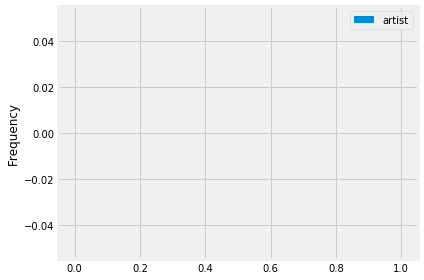

In [43]:
df = pd.DataFrame(results_df, columns=['artist'])
#df.plot.hist(bins=12)
df.plot.hist()
plt.tight_layout()
plt.show()
#plt.savefig("./histogram_hw8_JG.png")